In [1]:
import asyncio
import time
import math
import numpy as np
from cv2 import VideoCapture
import matplotlib.pyplot as plt
from matplotlib import colors
import Global
# from vision.module import detection, utils, constants
# from vision.functions import vision_init, get_thymio
from vision.functions import vision_init, get_thymio
# import vision_nav
from KF import KalmanFilter
from Control import Control
import cv2
from itertools import chain
import math
import MotionControl
import local_nav
from datetime import datetime


In [2]:
#Connecting to the tymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

Node 459c102c-e51f-4d84-ba38-ef5cd6b70951

In [3]:
thymio = Control(node,client)
tracker = KalmanFilter()

init


In [4]:
# aw(node.unlock())

In [5]:
#thymio.set_motors(0,"forward")

In [6]:
# ls,rs,prox = await thymio.get_sensors()
# display(ls)
# display(rs)
# display(prox)

In [7]:
# lock the camera resource
cap = VideoCapture(0)

In [8]:
grid = None
obs = []
obs_grid = None
targets = []
goal = []

# import constants
from vision.constants import grid_height_cells, grid_width_cells

In [9]:
#  vision initialization

flag, grid, obs, obs_grid, targets, goal = vision_init(cap)
print(obs_grid)

if not flag:
    assert 0

print(goal)
# if you get to this point, the vision is initialized and you have acquired information about the environment

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[2, 6]]


In [10]:
#Extracting targets to be in array and not matrix
targets = tuple([item for sublist in targets for item in sublist])


In [11]:
#Extracting goal to be in array and not matrix format
goal = tuple([item for sublist in goal for item in sublist])

In [12]:
display(goal)

(2, 6)

In [13]:
# !python -m pip install tk-tools

In [14]:
def create_empty_plot(width, height):
    
        fig, ax = plt.subplots(figsize=(width, height))

        major_ticks_x = np.arange(0, width+1, 5)
        minor_ticks_x = np.arange(0, width+1, 1)
        major_ticks_y = np.arange(0, height+1, 5)
        minor_ticks_y = np.arange(0, height+1, 1)

        ax.set_xticks(major_ticks_x)
        ax.set_xticks(minor_ticks_x, minor=True)
        ax.set_yticks(major_ticks_y)
        ax.set_yticks(minor_ticks_y, minor=True)
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

        ax.set_ylim([-1, height])
        ax.set_xlim([-1, width])
        ax.grid(True)

        return fig, ax

Text(0.5, 1.0, 'Map : free cells in white, occupied cells in red')

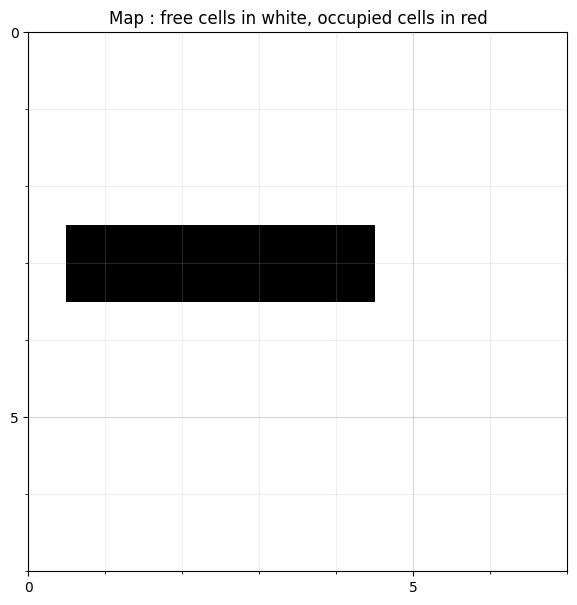

In [15]:
width = 7
height = 7
fig, ax = create_empty_plot(width,height)

# set plot origin to top left 
plt.xlim(0, width)
plt.ylim(height, 0)

# Displaying the map
cmap = colors.ListedColormap(['white', 'black'])
ax.imshow(obs_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red")

In [16]:
# List of all coordinates in the grid
#max_val is the size of the map
#x: 2D array where each element x[i, j] represents the x coordinate at position (i, j) in the grid.
#Donc x[1,n] rendra toujours 1 car la coord x d'un point en (1,n) est 1
#y: 2D array where each element y[i, j] represents the y coordinate at position (i, j) in the grid.
# List of all coordinates in the grid
x, y = np.mgrid[0:width:1, 0:height:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0] * x.shape[1], 2))

# Coords contains all the possible coordinates of the grid from (0,0) to (width-1, height-1)
coords = list([(int(x[1]), int(x[0])) for x in pos])

#Defining the start  point and end goal for now on
flag, t ,state = get_thymio(cap)
if flag:
    # start = tuple([state[0],state[1]]) # state[1]-0.5
    start = [state[0],state[1]]
    angle = state[2]
    print(start)
else:
    print("Problem with thymio_get function")
# start = tuple(map(np.floor,int(start)))
start = tuple([int(state[0]), int(state[1])])
print(start)

[5.59, 0.41]
(5, 0)


In [17]:
start

(5, 0)

In [18]:
#Defining the distance to the goal ignoring the obstacles, here using the Euclidian distance with the function np.linalg.norm
# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

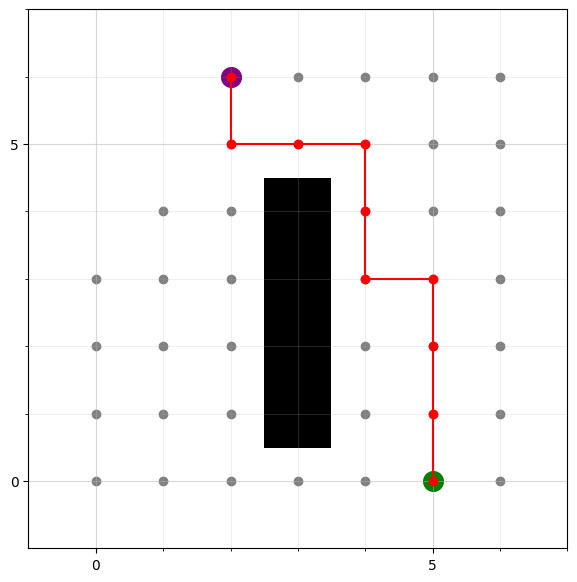

In [19]:
# Run the A* algorithm
path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(width, height)  # Use width and height here
ax_astar.imshow(obs_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color='grey')
ax_astar.plot(path[0], path[1], marker="o", color='red')
ax_astar.scatter(start[0], start[1], marker="o", color='green', s=200)
ax_astar.scatter(goal[0], goal[1], marker="o", color='purple', s=200)


In [20]:
print(path)


[[5 5 5 5 4 4 4 3 2 2]
 [0 1 2 3 3 4 5 5 5 6]]


In [21]:
#Checking the state of camera
camera_on = True
flag, _, state = get_thymio(cap)
if not flag:
    print("Problem with vision_nav function")
    camera_on = False
else:
    pos = tuple([state[0],state[1]])
    print("The position given by vision is:",pos)
    angle = state[2]

print(angle)

The position given by vision is: (5.59, 0.41)
88.43


In [22]:
from Control import Control
#Main 
index = 1
size_path = len(path[0])
old_pos = start
target = tuple(path[:,1])
epsilon = 0.18
Kidnapping_threshold = 2
arrived = False
is_kidnapped = False
sensor_scale = 200
old_pos = 0

prev_time = datetime.now()
first_run = True
test = 0

# PID 
integral = 0.0
previous_error = 0.0
nearest_point_idx = 0
# PID 

while size_path > index: 
    
    #Checking the state of camera
    camera_on = True
    flag, _, state = get_thymio(cap)
    time_start = datetime.now()
    time_difference = (time_start - prev_time).total_seconds()
    print("Time Difference: ", time_difference)
    print("Time Start: ", time_start)
    print("Time END: ", prev_time)

    prev_time = time_start

    #Motor speed
    speed_left, speed_right, prox = await thymio.get_sensors()
    speed = [speed_left,speed_right]
    print("SPEED Left :" , speed_left," AND right :", speed_right)

    # orientation_est = [orientation_est[1],orientation_est[0]]
    if flag:
        if first_run:
            print("index is 0 ")
            speed_xy, orientation_est, kal_angle = tracker.compute_x_y_speed(speed_left,speed_right,state[2],0)
            x_prev = [state[0],state[1],speed_xy[0]/10,speed_xy[1]/10]
            P_prev = np.eye(4)*1000
            kal_state,kal_speed,x_est,P_est,estimated_direction = tracker.predict(x_prev,P_prev,speed_xy, orientation_est,time_difference)
            first_run = False
            test += 1
            # target = tuple(path[:,index])
            # vector_to_checkpoint = (target[0]+0.5 - pos[0], target[1]+0.5 - pos[1])
            # print("First run target", target)
            # print("First run vector checkp", vector_to_checkpoint)
            # vec0 = vector_to_checkpoint[0]
            # if abs(vec0) < 0.15: vec0 = 0
            # vec1 = vector_to_checkpoint[1]
            # if abs(vec1) < 0.15: vec1 = 0
            # target_angle = np.degrees(np.arctan2(vec1,vec0))
            # if target[0]+0.5 - pos[0] > 0:
            #     target_angle = 0
            # elif target[0]+0.5 - pos[0] < 0:
            #     target_angle = 180
            # elif target[1]+0.5 - pos[1] > 0:
            #     target_angle = 90
            # else: # target[1]+0.5 - pos[1] < 0
            #     target_angle = -90
            # print("First run target angles ", target_angle)
        else:
            if test == 1 : 
                time_difference = 0.0534
            print("index for Kalman is : ", test)
            speed_xy, orientation_est, kal_angle = tracker.compute_x_y_speed(speed_left,speed_right,state[2],time_difference)
            x_prev = [pos[0],pos[1],speed_xy[0]/10,speed_xy[1]/10]
            P_prev = P_est
            kal_state,kal_speed,x_est,P_est,estimated_direction = tracker.predict(x_prev,P_prev,speed_xy, orientation_est,time_difference)
            test += 1
    else:
        print(" --- TAKEN FROM KALMAN --- ")
        speed_xy, orientation_est, kal_angle = tracker.compute_x_y_speed(speed_left,speed_right,kal_angle,time_difference)
        x_prev = [pos[0],pos[1],speed_xy[0]/10,speed_xy[1]/10]
        P_prev = P_est
        kal_state,kal_speed,x_est,P_est,estimated_direction = tracker.predict(x_prev,P_prev, speed_xy, orientation_est,time_difference)

    if not flag:
        print("Problem with vision_nav function")
        camera_on = False
        pos = tuple([kal_state[0],kal_state[1]])
        angle = kal_angle
    else:
        pos = tuple([state[0],state[1]])
        # print("The position given by vision is:",pos)
        angle = state[2]
        kal_angle = angle

    print(" POSITION KALMAN :", kal_state)
    print(" REAL POSITION FROM CAM : ", pos)
    print(" DIRECTION KALMAN :", estimated_direction)
    print(" ANGLE FROM KALMAN :", kal_angle)
    print(" ANGLE FROM CAMERA IN MAIN", angle)

    # print(speed)
    # print(camera_on)
    
    #calculer la norm old pos vs pos --> si superieur a treshold kidnapping
    old_pos = tuple(path[:,index-1])
    distance = math.sqrt((pos[0] - old_pos[0])**2 + (pos[1] - old_pos[1])**2)
    #print("Kidnapped distance is : ---------------------------- ", distance)
    if ((distance > Kidnapping_threshold) and (is_kidnapped == False)):
        #Need to initialize kidnapping_threshold with a value
        #recompute vision to get the new position-> this new position is the new start point, the goal remain unchanged
        flag, _, state = get_thymio(cap)
        if flag:
            pos = tuple([state[0]-0.5,state[1]])
            angle = state[2]
            kal_angle = angle
        else:
            pos = tuple([kal_state[0],kal_state[1]])
            # print("The position given by vision is:",pos)
            angle = kal_angle 
            # print("Problem with thymio_get function")
        thymio.set_motors_PID(0,0)
        start = tuple([int(pos[0]),int(pos[1])])
        path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N")
        await client.sleep(0.2)
        path = np.array(path).reshape(-1, 2).transpose()
        visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
        index = 0 #The index need to be re-initialized since we have a new path
        target = tuple(path[:,index+1])
        is_kidnapped = True
        # print(" KIDNAPPEEDDD ")
        # print(" The new path : ", path)

    # #start leds and sound

    #Need to add obstacle avoidance
    obstacle_detected  = await local_nav.local_nav(thymio)
    if(obstacle_detected):
        #print( "Path for local : ", list(path[:,index+1:index+4]))
        status = local_nav.obstacle_function(path[:,index+1:index+4],pos,thymio)
        obstacle_detected = False
        target = tuple(path[:,index+status])
        index = index+status
 
    #Motion control
    # print("thymio position:", pos)
    # print("thymio angle:", angle)
    print("target", target)
    print(" POS FOR THE VECTOR OF CHECKPOINT : ", pos)

    left_speed, right_speed, _ = await thymio.get_sensors()
    vector_to_checkpoint = (target[0]+0.5 - pos[0], target[1]+0.5 - pos[1])
    vec0 = vector_to_checkpoint[0]
    # if abs(vec0) < 0.15: vec0 = 0
    vec1 = vector_to_checkpoint[1]
    # if abs(vec1) < 0.15: vec1 = 0
    
    target_angle = np.degrees(np.arctan2(vec1,vec0))
    print(" Vector to checkpoint :", vector_to_checkpoint)
    print("target angle", target_angle)
    print(" ANGLE : ", angle)
    target_angle = MotionControl.normalize_angle(target_angle)
    angle = MotionControl.normalize_angle(angle)
    error = MotionControl.normalize_angle(target_angle - angle)
    print(" ERROR ANGLE FOR PID : ", error)
    print(" INTEGRAL ERROR ANGLE FOR PID : ", integral)
    print(" DERIVATIVE ERROR ANGLE FOR PID : ", previous_error)
    #test_angle = np.degrees(np.arctan2(vector_to_checkpoint[1],vector_to_checkpoint[0]))+180
    updated_left_speed,updated_right_speed, integral,previous_error, turning = await(MotionControl.pid_controller(integral, error, previous_error))
    print( " UPDATED MOTOR SPEEDS  left : ", updated_left_speed, " RIGHT :", updated_right_speed)
    thymio.set_motors_PID(updated_left_speed,updated_right_speed)
    await client.sleep(0.2)

    # print("The vector to check point : ",vector_to_checkpoint)
    # print("The angle computed before: ", error)
    # print("Error : ", error)
    print("Turning: ", turning)
    # while turning == True :
    #     thymio.set_motors_PID(updated_left_speed,updated_right_speed)
    #     await client.sleep(0.5)
    #     if camera_on == True:
    #         flag,_,state = get_thymio(cap)
    #         if not flag:
    #             #print("Problem with vision_nav function")
    #             camera_on = False
    #         else:
    #             pos = tuple([state[0],state[1]])
    #             pid_angle = state[2]
    #     elif camera_on == False :
    #         tracker = KalmanFilter()
    #         speed_xy, orientation_est, kal_angle = tracker.compute_x_y_speed(speed[0],speed[1],kal_angle)
    #         x_est = [pos[0],pos[1],speed_xy[0]/10,speed_xy[1]/10]
    #         P_est = np.eye(4)*1000
    #         kal_state,kal_speed,x_est,P_est,estimated_direction = tracker.predict(speed[0],speed[1],x_est,P_est,kal_angle)
    #         pid_angle = np.degrees(angle_est)
    #     error = MotionControl.normalize_angle(target_angle - pid_angle)
    #     #print(" ERROR EQUIV :", error)
    #     updated_left_speed,updated_right_speed, integral,previous_error, turning = await(MotionControl.pid_controller(integral, error, previous_error))

    # thymio.set_motors_PID(80,80)
    # await client.sleep(0.2)
    
    # print("closeness:", np.linalg.norm(path[:,idx]-np.array(pos)))
    # print("y difference:",np.abs(path[:,idx][1]-np.array(pos[1])))
    f1 = (np.abs((target[1]+0.5-np.array(pos[1])) ) <= epsilon)
    f2 = (np.abs((target[0]+0.5-np.array(pos[0])) ) <= epsilon)
    f3 = (index<size_path)
    print(f1, f2, f3)
    # if (f1 and f3) or (f2 and f3):
    if f1 and f2 and f3:
        #print("Prev index: ", index)
        if index == size_path-1:
            print("Arrived")
        else:
            target = tuple(path[:,index+1])

            # vector_to_checkpoint = (target[0]+0.5 - pos[0], target[1]+0.5 - pos[1])
            # vec0 = vector_to_checkpoint[0]
            # if abs(vec0) < 0.15: vec0 = 0
            # vec1 = vector_to_checkpoint[1]
            # if abs(vec1) < 0.15: vec1 = 0
            # target_angle = np.degrees(np.arctan2(vec1,vec0))
            # # if target[0]+0.5 - pos[0] > 0:
            #     target_angle = 0
            # elif target[0]+0.5 - pos[0] < 0:
            #     target_angle = 180
            # elif target[1]+0.5 - pos[1] > 0:
            #     target_angle = 90
            # else: # target[1]+0.5 - pos[1] < 0
            #     target_angle = -90

            print(" Vector to checkpoint :", vector_to_checkpoint)
        index = index+1
        arrived = False
        # print("new target is : ", target)
        # print("INDEX IS ACTUALLY : ", index)
    # else:
    #     thymio.set_motors_PID(0,0)

    #start leds and sound

#print("end")
thymio.set_motors_PID(0,0)

Time Difference:  0.030583
Time Start:  2023-12-06 17:12:26.335278
Time END:  2023-12-06 17:12:26.304695
SPEED Left : 0  AND right : 0
index is 0 
-------------delta  0.0
-------------New dir: [0.         0.99924946]
 POSITION KALMAN : [5.6  0.41]
 REAL POSITION FROM CAM :  (5.6, 0.41)
 DIRECTION KALMAN : [0.         0.99924946]
 ANGLE FROM KALMAN : 87.78
 ANGLE FROM CAMERA IN MAIN 87.78
target (5, 1)
 POS FOR THE VECTOR OF CHECKPOINT :  (5.6, 0.41)
 Vector to checkpoint : (-0.09999999999999964, 1.09)
target angle 95.24181994697955
 ANGLE :  87.78
 ERROR ANGLE FOR PID :  7.461819946979546
 INTEGRAL ERROR ANGLE FOR PID :  0.0
 DERIVATIVE ERROR ANGLE FOR PID :  0.0
 UPDATED MOTOR SPEEDS  left :  73.0  RIGHT : 87.0
SETTING PID
Turning:  False
False True True
Time Difference:  0.465807
Time Start:  2023-12-06 17:12:26.801085
Time END:  2023-12-06 17:12:26.335278
SPEED Left : 0  AND right : 0
index for Kalman is :  1
-------------delta  0.0
-------------New dir: [0.         0.99960523]
 POS

In [23]:
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
aw(node.set_variables(v))


In [ ]:
time_start = datetime.now()
thymio.set_motors_PID(80,80)
# for _ in range(10):
#     speed_left, speed_right, prox = await thymio.get_sensors()
#     speed_left, speed_right, prox = await thymio.get_sensors()
#     print(speed_left, speed_right)
#     await client.sleep(0.5)

# thymio.set_motors_PID(0,0)

SETTING PID


In [ ]:
stop = datetime.now()
thymio.set_motors_PID(0,0)
print((time_start - stop).total_seconds())

SETTING PID
-32.394715


In [ ]:
# release the camera resource
cap.release()

In [ ]:
aw(node.unlock())

{'error_code': 2}